In [1]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Load two csv.
Create Main DataFrame.
Clean Dataframe by replacing Nan and duplicates
Remove war columns that could skew Neural Network

In [40]:
# Create Dataframe for war dataset
url = 'https://baseballwar.s3.us-west-1.amazonaws.com/Resources/jeffbagwell_war_historical.csv'
war_df = pd.read_csv(url, encoding='latin-1')
war_df.head()


,player_name,age,key_bbref,year_ID,team_ID,stint_ID,lg_ID,is_P,franch_ID,sched,...,gms_RF,gms_OF,gms_DH,gms_PH,gms_PR,prev_tm,arrived,departed,next_tm,salary
0,David Aardsma,22.0,aardsda01,2004,SFG,1,NL,Y,SFG,162,...,0.0,0.0,0.0,0.0,0.0,---,2004,2004,CHC,300000.0
1,David Aardsma,24.0,aardsda01,2006,CHC,1,NL,Y,CHC,162,...,0.0,0.0,0.0,0.0,0.0,SFG,2006,2006,CHW,NaN
2,David Aardsma,25.0,aardsda01,2007,CHW,1,AL,Y,CHW,162,...,0.0,0.0,0.0,0.0,0.0,CHC,2007,2007,BOS,387500.0
3,David Aardsma,26.0,aardsda01,2008,BOS,1,AL,Y,BOS,162,...,0.0,0.0,0.0,0.0,0.0,CHW,2008,2008,SEA,403250.0
4,David Aardsma,27.0,aardsda01,2009,SEA,1,AL,Y,SEA,162,...,0.0,0.0,0.0,0.0,0.0,BOS,2009,2010,NYY,419000.0


In [3]:
# Create seperate Dataframe for injury dataset
url2 = 'https://raw.githubusercontent.com/brianrwheatley/final-baseball-war-stats/finding_injury_length/final_injury_data.csv'
injury_df = pd.read_csv(url2)
injury_df.head()


,Unnamed: 0,Name,Team,Date,Status,injury_length,Injury,location,days_injured,year,shortname
0,0,Brian Johnson,Red Sox,6/15/17,Placed,10-day,shoulder impingement,left,NaN,2017,bjohnson
1,1,Brian Johnson,Red Sox,7/6/17,Activated,10-day,NaN,NaN,21.0,2017,bjohnson
2,2,Brian Johnson,Red Sox,7/8/18,Placed,10-day,hip inflammation,left,NaN,2018,bjohnson
3,3,Brian Johnson,Red Sox,7/15/18,Activated,10-day,NaN,NaN,7.0,2018,bjohnson
4,4,Brian Johnson,Red Sox,4/6/19,Placed,10-day,elbow inflammation,left,NaN,2019,bjohnson


In [4]:
# Filter Dataframe to years in question >=2010
war_df=war_df[war_df.year_ID >=2010]
war_df

,player_name,age,key_bbref,year_ID,team_ID,stint_ID,lg_ID,is_P,franch_ID,sched,...,gms_RF,gms_OF,gms_DH,gms_PH,gms_PR,prev_tm,arrived,departed,next_tm,salary
5,David Aardsma,28.0,aardsda01,2010,SEA,1,AL,Y,SEA,162,...,0.0,0.0,0.0,0.0,0.0,BOS,2009,2010,NYY,2750000.0
6,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,0.0,0.0,0.0,0.0,0.0,SEA,2012,2012,NYM,500000.0
7,David Aardsma,31.0,aardsda01,2013,NYM,1,NL,Y,NYM,162,...,0.0,0.0,0.0,0.0,0.0,NYY,2013,2013,ATL,NaN
8,David Aardsma,33.0,aardsda01,2015,ATL,1,NL,Y,ATL,162,...,0.0,0.0,0.0,0.0,0.0,NYM,2015,2015,---,NaN
55,Fernando Abad,24.0,abadfe01,2010,HOU,1,NL,Y,HOU,162,...,0.0,0.0,0.0,0.0,0.0,---,2010,2012,WSN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111976,Mike Zunino,30.0,zuninmi01,2021,TBR,1,AL,N,TBD,162,...,0.0,0.0,0.0,5.0,0.0,SEA,2019,2022,---,2000000.0
111977,Mike Zunino,31.0,zuninmi01,2022,TBR,1,AL,N,TBD,29,...,0.0,0.0,0.0,2.0,0.0,SEA,2019,2022,---,7000000.0
112009,Tony Zych,24.0,zychto01,2015,SEA,1,AL,Y,SEA,162,...,0.0,0.0,0.0,0.0,0.0,---,2015,2017,---,NaN
112010,Tony Zych,25.0,zychto01,2016,SEA,1,AL,Y,SEA,162,...,0.0,0.0,0.0,0.0,0.0,---,2015,2017,---,511000.0


In [5]:
# Combine same year and player in Injury_df
new_injury_df = injury_df.groupby(["Name", "year"]).agg({"Team": "first", "Name": "first", "Team" : "first","injury_length": "first", "Injury": "first", "location": "first", "days_injured" : "first", "year": "first", "shortname": "first"} )

#injury_df.groupby(["Name", "year"])
new_injury_df.to_csv("clean_injury.csv")

In [6]:
# Create a csv with cleaned injury data
new_injury_df.to_csv("clean_injury.csv")

In [7]:
# Merge of two dataframes.  
injury_war_df = pd.merge(war_df, injury_df, how = 'left', left_on= ['player_name', 'year_ID'], right_on= ["Name", "year"])
injury_war_df.head()

,player_name,age,key_bbref,year_ID,team_ID,stint_ID,lg_ID,is_P,franch_ID,sched,...,Name,Team,Date,Status,injury_length,Injury,location,days_injured,year,shortname
0,David Aardsma,28.0,aardsda01,2010,SEA,1,AL,Y,SEA,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,David Aardsma,Yankees,2/27/12,Placed,60-day,NaN,NaN,NaN,2012.0,daardsma
2,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,David Aardsma,Yankees,9/25/12,Activated,60-day,NaN,NaN,211.0,2012.0,daardsma
3,David Aardsma,31.0,aardsda01,2013,NYM,1,NL,Y,NYM,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,David Aardsma,33.0,aardsda01,2015,ATL,1,NL,Y,ATL,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Save Cleaned and added Dataframe to CSV
injury_war_df.to_csv("clean_injury_war.csv")

In [9]:
# Sort the dataset by names first, then by date
#injury_war_df = injury_war_df.sort_values(by = ['player_name', 'year_ID'], ascending = [True, True], na_position = 'first')
# injury_war_df

In [10]:
# Create columns for WAR_difference to show increase or decrease of war by year; Second column WAR_change will be (1 represent positive change (>0) and 0 will be decline in war )
# injury_war_df['WAR_difference'] = ''
# injury_war_df['WAR_change'] = ''

injury_war_df

,player_name,age,key_bbref,year_ID,team_ID,stint_ID,lg_ID,is_P,franch_ID,sched,...,Name,Team,Date,Status,injury_length,Injury,location,days_injured,year,shortname
0,David Aardsma,28.0,aardsda01,2010,SEA,1,AL,Y,SEA,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,David Aardsma,Yankees,2/27/12,Placed,60-day,NaN,NaN,NaN,2012.0,daardsma
2,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,David Aardsma,Yankees,9/25/12,Activated,60-day,NaN,NaN,211.0,2012.0,daardsma
3,David Aardsma,31.0,aardsda01,2013,NYM,1,NL,Y,NYM,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,David Aardsma,33.0,aardsda01,2015,ATL,1,NL,Y,ATL,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26210,Tony Zych,25.0,zychto01,2016,SEA,1,AL,Y,SEA,162,...,Tony Zych,Mariners,8/23/16,Activated,60-day,NaN,NaN,112.0,2016.0,tzych
26211,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Tony Zych,Mariners,3/31/17,Placed,10-day,recovering from surgery on biceps,right,NaN,2017.0,tzych
26212,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Tony Zych,Mariners,4/14/17,Activated,10-day,NaN,NaN,14.0,2017.0,tzych
26213,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Tony Zych,Mariners,8/22/17,Placed,10-day,strained flexor bundle in elbow (out for season),right,NaN,2017.0,tzych


In [11]:
injury_war_df[["player_name", "WAR162",]]

,player_name,WAR162
0,David Aardsma,0.660000
1,David Aardsma,-0.040000
2,David Aardsma,-0.040000
3,David Aardsma,-0.276667
4,David Aardsma,-0.245000
...,...,...
26210,Tony Zych,0.140000
26211,Tony Zych,0.816667
26212,Tony Zych,0.816667
26213,Tony Zych,0.816667


In [12]:
# Create a list of player_name and 
player_list = injury_war_df['player_name'].tolist()
war162_list = injury_war_df['WAR162'].tolist()
new_list = [player_list, war162_list]

In [13]:
#Create empty list.  Create count/length of player list.  For player (i) in the range of length, if player equl to player plus one year and continue take WAR162 difference between those years.  Else add zero to column due to new player that is not match
war_difference_list = [0]
length = len(player_list)
for i in range(length-1):
    if player_list[i] == player_list[i+1]:
        war_difference_list.append(war162_list[i] - war162_list[i+1])
    else:
        war_difference_list.append(0)


In [14]:
# Add the new value as column to Dataframe
injury_war_df["WAR_difference"] = war_difference_list
injury_war_df

,player_name,age,key_bbref,year_ID,team_ID,stint_ID,lg_ID,is_P,franch_ID,sched,...,Team,Date,Status,injury_length,Injury,location,days_injured,year,shortname,WAR_difference
0,David Aardsma,28.0,aardsda01,2010,SEA,1,AL,Y,SEA,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,Yankees,2/27/12,Placed,60-day,NaN,NaN,NaN,2012.0,daardsma,0.700000
2,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,Yankees,9/25/12,Activated,60-day,NaN,NaN,211.0,2012.0,daardsma,0.000000
3,David Aardsma,31.0,aardsda01,2013,NYM,1,NL,Y,NYM,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236667
4,David Aardsma,33.0,aardsda01,2015,ATL,1,NL,Y,ATL,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.031667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26210,Tony Zych,25.0,zychto01,2016,SEA,1,AL,Y,SEA,162,...,Mariners,8/23/16,Activated,60-day,NaN,NaN,112.0,2016.0,tzych,0.000000
26211,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Mariners,3/31/17,Placed,10-day,recovering from surgery on biceps,right,NaN,2017.0,tzych,-0.676667
26212,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Mariners,4/14/17,Activated,10-day,NaN,NaN,14.0,2017.0,tzych,0.000000
26213,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Mariners,8/22/17,Placed,10-day,strained flexor bundle in elbow (out for season),right,NaN,2017.0,tzych,0.000000


In [15]:
# Check the War difference has been succesfully accomplished
injury_war_df[["player_name", "WAR162", "WAR_difference"]]

,player_name,WAR162,WAR_difference
0,David Aardsma,0.660000,0.000000
1,David Aardsma,-0.040000,0.700000
2,David Aardsma,-0.040000,0.000000
3,David Aardsma,-0.276667,0.236667
4,David Aardsma,-0.245000,-0.031667
...,...,...,...
26210,Tony Zych,0.140000,0.000000
26211,Tony Zych,0.816667,-0.676667
26212,Tony Zych,0.816667,0.000000
26213,Tony Zych,0.816667,0.000000


In [16]:
# Take the WAR_Difference value of a row and designate if if it was positive or negative 
injury_war_df["WAR_change"] = np.where(injury_war_df["WAR_difference"] > 0, 1, 0)
injury_war_df

,player_name,age,key_bbref,year_ID,team_ID,stint_ID,lg_ID,is_P,franch_ID,sched,...,Date,Status,injury_length,Injury,location,days_injured,year,shortname,WAR_difference,WAR_change
0,David Aardsma,28.0,aardsda01,2010,SEA,1,AL,Y,SEA,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
1,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,2/27/12,Placed,60-day,NaN,NaN,NaN,2012.0,daardsma,0.700000,1
2,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,9/25/12,Activated,60-day,NaN,NaN,211.0,2012.0,daardsma,0.000000,0
3,David Aardsma,31.0,aardsda01,2013,NYM,1,NL,Y,NYM,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236667,1
4,David Aardsma,33.0,aardsda01,2015,ATL,1,NL,Y,ATL,162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.031667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26210,Tony Zych,25.0,zychto01,2016,SEA,1,AL,Y,SEA,162,...,8/23/16,Activated,60-day,NaN,NaN,112.0,2016.0,tzych,0.000000,0
26211,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,3/31/17,Placed,10-day,recovering from surgery on biceps,right,NaN,2017.0,tzych,-0.676667,0
26212,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,4/14/17,Activated,10-day,NaN,NaN,14.0,2017.0,tzych,0.000000,0
26213,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,8/22/17,Placed,10-day,strained flexor bundle in elbow (out for season),right,NaN,2017.0,tzych,0.000000,0


In [17]:
# Check Value Counts of new column
injury_war_df.WAR_change.value_counts()


0    18745
1     7470
Name: WAR_change, dtype: int64

In [18]:
# Create column if war is above 2 (replacement level of solid starter)  
# Check value counts of new column
injury_war_df["above_average_war"] = [1 if x >= 2 else 0 for x in injury_war_df["WAR162"]]
injury_war_df.above_average_war.value_counts()

0    22300
1     3915
Name: above_average_war, dtype: int64

In [19]:
# Use dtypes to check column values
injury_war_df.dtypes

player_name           object
age                  float64
key_bbref             object
year_ID                int64
team_ID               object
                      ...   
year                 float64
shortname             object
WAR_difference       float64
WAR_change             int64
above_average_war      int64
Length: 92, dtype: object

In [20]:
# Replace Nan in injury with none, replace days injured with o, location with none, salary with 0
injury_war_df['Injury'] = injury_war_df['Injury'].replace(np.nan, "none")
injury_war_df['days_injured'] = injury_war_df['days_injured'].replace(np.nan, 0)
injury_war_df['location'] = injury_war_df['location'].replace(np.nan, "none")
injury_war_df['salary'] = injury_war_df['salary'].replace(np.nan, 0)


injury_war_df

,player_name,age,key_bbref,year_ID,team_ID,stint_ID,lg_ID,is_P,franch_ID,sched,...,Status,injury_length,Injury,location,days_injured,year,shortname,WAR_difference,WAR_change,above_average_war
0,David Aardsma,28.0,aardsda01,2010,SEA,1,AL,Y,SEA,162,...,NaN,NaN,none,none,0.0,NaN,NaN,0.000000,0,0
1,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,Placed,60-day,none,none,0.0,2012.0,daardsma,0.700000,1,0
2,David Aardsma,30.0,aardsda01,2012,NYY,1,AL,Y,NYY,162,...,Activated,60-day,none,none,211.0,2012.0,daardsma,0.000000,0,0
3,David Aardsma,31.0,aardsda01,2013,NYM,1,NL,Y,NYM,162,...,NaN,NaN,none,none,0.0,NaN,NaN,0.236667,1,0
4,David Aardsma,33.0,aardsda01,2015,ATL,1,NL,Y,ATL,162,...,NaN,NaN,none,none,0.0,NaN,NaN,-0.031667,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26210,Tony Zych,25.0,zychto01,2016,SEA,1,AL,Y,SEA,162,...,Activated,60-day,none,none,112.0,2016.0,tzych,0.000000,0,0
26211,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Placed,10-day,recovering from surgery on biceps,right,0.0,2017.0,tzych,-0.676667,0,0
26212,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Activated,10-day,none,none,14.0,2017.0,tzych,0.000000,0,0
26213,Tony Zych,26.0,zychto01,2017,SEA,1,AL,Y,SEA,162,...,Placed,10-day,strained flexor bundle in elbow (out for season),right,0.0,2017.0,tzych,0.000000,0,0


In [21]:
# Count NaN
count_nan_in_df = injury_war_df.isnull().sum()
print(count_nan_in_df)


player_name              0
age                      0
key_bbref                0
year_ID                  0
team_ID                  0
                     ...  
year                 13565
shortname            13565
WAR_difference           0
WAR_change               0
above_average_war        0
Length: 92, dtype: int64


In [22]:
# Print list on NaN columns
injury_war_df.columns[injury_war_df.isna().any()].tolist()

['BB_plus',
 'K_plus',
 'AVG_plus',
 'OBP_plus',
 'SLG_plus',
 'wRC_plus',
 'ISO_plus',
 'BABIP_plus',
 'LD_plus',
 'GB_plus',
 'FB_plus',
 'Pull_plus',
 'Cent_plus',
 'Oppo_plus',
 'g_pitch',
 'starts',
 'relief_pct',
 'avg_LI',
 'fg_pwar162',
 'ra9_pwar162',
 'K9_plus',
 'BB9_plus',
 'KBB_plus',
 'HR9_plus',
 'Kpct_plus',
 'BBpct_plus',
 'oppAVG_plus',
 'WHIP_plus',
 'oppBABIP_plus',
 'LOB_plus',
 'ERA_minus',
 'FIP_minus',
 'xFIP_minus',
 'oppLD_plus',
 'oppGB_plus',
 'oppFB_plus',
 'Unnamed: 0',
 'Name',
 'Team',
 'Date',
 'Status',
 'injury_length',
 'year',
 'shortname']

In [23]:
# Replace Stats with zero.  Zero due to pitchers and postion players not recieving same stats
injury_war_df = injury_war_df.replace(np.nan, 0)

In [24]:
# Save Cleaned and added Dataframe to CSV
injury_war_df.to_csv("clean_injury_war.csv")

In [25]:
# # Drop the non-beneficial and duplicate ID columns, "Name", "player_name", "key_bbref", "franch_ID", "prev_tm", "next_tm", "Unnamed: 0", "Name", "Team", "Date",'shortname', "year", "injury_length", "Status"  .
injury_war_df = injury_war_df.drop(columns=["Name", "player_name", "key_bbref", "franch_ID", "prev_tm", "next_tm", "Unnamed: 0", "Name", "Team", "Date",'shortname', "year", "injury_length", "Status"])
injury_war_df

,age,year_ID,team_ID,stint_ID,lg_ID,is_P,sched,g_bat,pa,bat162,...,gms_PR,arrived,departed,salary,Injury,location,days_injured,WAR_difference,WAR_change,above_average_war
0,28.0,2010,SEA,1,AL,Y,162,4,0,0.00,...,0.0,2009,2010,2750000.0,none,none,0.0,0.000000,0,0
1,30.0,2012,NYY,1,AL,Y,162,0,0,0.00,...,0.0,2012,2012,500000.0,none,none,0.0,0.700000,1,0
2,30.0,2012,NYY,1,AL,Y,162,0,0,0.00,...,0.0,2012,2012,500000.0,none,none,211.0,0.000000,0,0
3,31.0,2013,NYM,1,NL,Y,162,41,0,0.00,...,0.0,2013,2013,0.0,none,none,0.0,0.236667,1,0
4,33.0,2015,ATL,1,NL,Y,162,30,1,-0.28,...,0.0,2015,2015,0.0,none,none,0.0,-0.031667,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26210,25.0,2016,SEA,1,AL,Y,162,0,0,0.00,...,0.0,2015,2017,511000.0,none,none,112.0,0.000000,0,0
26211,26.0,2017,SEA,1,AL,Y,162,4,0,0.00,...,0.0,2015,2017,539600.0,recovering from surgery on biceps,right,0.0,-0.676667,0,0
26212,26.0,2017,SEA,1,AL,Y,162,4,0,0.00,...,0.0,2015,2017,539600.0,none,none,14.0,0.000000,0,0
26213,26.0,2017,SEA,1,AL,Y,162,4,0,0.00,...,0.0,2015,2017,539600.0,strained flexor bundle in elbow (out for season),right,0.0,0.000000,0,0


In [26]:
# Drop other war categories that are based off BWAR162 
injury_war_df = injury_war_df.drop(columns=["bwar162", "pwar162", "ra9_pwar162", "rep162", "fg_pwar162"])

Check Values of Dataframe.
Bin the injuries and bwar for machine learning

In [27]:
# Check the number of unique values in each column
injury_war_df.nunique()

age                    29
year_ID                13
team_ID                31
stint_ID                5
lg_ID                   2
                     ... 
location                4
days_injured          240
WAR_difference       9503
WAR_change              2
above_average_war       2
Length: 74, dtype: int64

In [28]:
# Look at Injury value counts for binning

counts = injury_war_df.Injury.value_counts()
counts.to_csv('injury_type.csv')
counts

none                                                 20045
strained  hamstring                                    464
strained  oblique                                      216
 shoulder inflammation                                 186
strained  shoulder                                     175
                                                     ...  
laceration on  hand/finger                               1
 back tightness                                          1
 tricep injury                                           1
non-baseball medical condition                           1
strained flexor bundle in  elbow (out for season)        1
Name: Injury, Length: 1366, dtype: int64

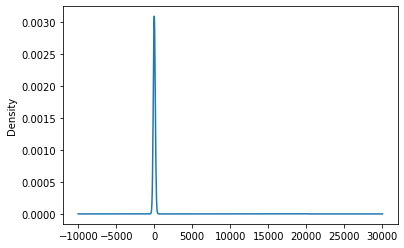

In [29]:
# Visualize the value counts of Notes
counts.plot.density()

In [30]:
 # Determine which values to replace if counts are less than ...?
replace_injury = list(counts[counts <10].index)

# Replace in dataframe
for injury in replace_injury:
     injury_war_df.Injury = injury_war_df.Injury.replace(injury,"Other")
    
# Check to make sure binning was successful
injury_war_df.Injury.value_counts()


none                      20045
Other                      2184
strained  hamstring         464
strained  oblique           216
 shoulder inflammation      186
                          ...  
strained  quadricep          10
dislocated  shoulder         10
sore  wrist                  10
viral infection              10
 triceps inflammation        10
Name: Injury, Length: 99, dtype: int64

Hot Encode categorical Variables.
Create a Seperate Dataframe.
Merge hot encoded dataframe to injury_war_df

In [31]:
# Generate our categorical variable lists
categorical_variable = list(injury_war_df.dtypes[injury_war_df.dtypes == "object"].index)
categorical_variable

['team_ID', 'lg_ID', 'is_P', 'Injury', 'location']

In [32]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(injury_war_df[categorical_variable]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(categorical_variable)
encode_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,team_ID_ARI,team_ID_ATL,team_ID_BAL,team_ID_BOS,team_ID_CHC,team_ID_CHW,team_ID_CIN,team_ID_CLE,team_ID_COL,team_ID_DET,...,Injury_torn ACL in knee,Injury_torn UCL in elbow,Injury_torn ligament in thumb,Injury_torn meniscus in knee,Injury_undisclosed injury,Injury_viral infection,location_left,location_none,location_right,location_rightleft
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
# Merge one-hot encoded features and drop the originals
injury_war_df = injury_war_df.merge(encode_df,left_index=True,right_index=True).drop(columns = categorical_variable)
injury_war_df

,age,year_ID,stint_ID,sched,g_bat,pa,bat162,bsr162,fld162,pos162,...,Injury_torn ACL in knee,Injury_torn UCL in elbow,Injury_torn ligament in thumb,Injury_torn meniscus in knee,Injury_undisclosed injury,Injury_viral infection,location_left,location_none,location_right,location_rightleft
0,28.0,2010,1,162,4,0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,30.0,2012,1,162,0,0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,30.0,2012,1,162,0,0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,31.0,2013,1,162,41,0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,33.0,2015,1,162,30,1,-0.28,0.0,0.0,0.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26210,25.0,2016,1,162,0,0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26211,26.0,2017,1,162,4,0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26212,26.0,2017,1,162,4,0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26213,26.0,2017,1,162,4,0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
# Split our preprocessed data into our features and target arrays
y  = injury_war_df.WAR_change.values
X = injury_war_df.drop(columns="WAR_change").values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [35]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

 Compile, Train and Evaluate the Model

In [36]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

number_input_features = len(X_train[0])
hidden_nodes_layer1 = 120
hidden_nodes_layer2 = 100
hidden_nodes_layer3 = 80
hidden_nodes_layer4 = 40
hidden_nodes_layer5 = 20
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)


# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# Fitfth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               24840     
                                                                 
 dense_1 (Dense)             (None, 100)               12100     
                                                                 
 dense_2 (Dense)             (None, 80)                8080      
                                                                 
 dense_3 (Dense)             (None, 40)                3240      
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 49,101
Trainable params: 49,101
Non-traina

In [37]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [38]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100)

Epoch 1/100
615/615 [==============================] - 5s 5ms/step - loss: 1544.1284 - accuracy: 0.6128
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 167.3450 - accuracy: 0.6350
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 90.2370 - accuracy: 0.6436
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 145.8470 - accuracy: 0.6349
Epoch 5/100
615/615 [==============================] - 2s 4ms/step - loss: 22.6907 - accuracy: 0.6444
Epoch 6/100
615/615 [==============================] - 2s 4ms/step - loss: 8.4335 - accuracy: 0.6524
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 5.2918 - accuracy: 0.6527
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 41.0237 - accuracy: 0.6579
Epoch 9/100
615/615 [==============================] - 2s 3ms/step - loss: 10.0749 - accuracy: 0.6585
Epoch 10/100
615/615 [==============================] - 2s 3ms/step - loss: 0.93

In [39]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

205/205 - 0s - loss: 0.4050 - accuracy: 0.9039 - 489ms/epoch - 2ms/step
Loss: 0.4049992859363556, Accuracy: 0.903875470161438
